# Phân loại bệnh tiểu đường (Pima Indians Diabetes)




## 1. Định nghĩa vấn đề (Define Problem)

- **Bộ dữ liệu**: Pima Indians Diabetes (768 mẫu, 9 thuộc tính).
- **Mục tiêu**: Xây dựng mô hình phân loại, dự đoán khả năng mắc bệnh tiểu đường.
- **Các thuộc tính**:
  1. Pregnancies – số lần mang thai
  2. Glucose – nồng độ glucose huyết tương
  3. BloodPressure – huyết áp tâm trương
  4. SkinThickness – độ dày da gấp
  5. Insulin – nồng độ insulin
  6. BMI – chỉ số khối cơ thể
  7. DiabetesPedigreeFunction – chỉ số nguy cơ di truyền
  8. Age – tuổi
  9. Outcome – nhãn (0 = không tiểu đường, 1 = tiểu đường)



**Nhận xét:**  
- Bài toán tập trung vào việc **dự đoán khả năng mắc bệnh tiểu đường** dựa trên các thông tin y tế như: số lần mang thai, nồng độ glucose, huyết áp, chỉ số BMI, độ dày da, insulin, v.v.  
- Đây là một bài toán **phân loại nhị phân** (0 = không mắc bệnh, 1 = mắc bệnh).  
- Việc xác định sớm nguy cơ mắc bệnh tiểu đường có ý nghĩa quan trọng trong y tế dự phòng, giúp phát hiện sớm và can thiệp kịp thời.  
- Thách thức chính của bài toán: dữ liệu chứa nhiều giá trị thiếu/không hợp lệ, sự mất cân bằng giữa hai lớp (*Outcome* = 0 chiếm đa số).  




## 2. Chuẩn bị vấn đề (Prepare Problem)

Trong phần này, ta sẽ:
- Import các thư viện cần thiết.
- Nạp bộ dữ liệu `pima-indians-diabetes.data.csv`.
- Xem thông tin cơ bản của dữ liệu.


### 2.1. Khai báo thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### 2.2. Nạp dữ liệu

In [2]:
column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]

df = pd.read_csv("pima-indians-diabetes.data.csv", names=column_names)

# Hiển thị 5 dòng đầu
print("5 dòng đầu dữ liệu:")
print(df.head())

# Thông tin tổng quan
print("\nThông tin dữ liệu:")
print(df.info())

print("\nThống kê mô tả:")
print(df.describe())


5 dòng đầu dữ liệu:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    in

## Nhận xét dữ liệu ban đầu

* Dữ liệu có **768 dòng** và **9 cột**, bao gồm cả biến đầu ra `Outcome` (0: không mắc tiểu đường, 1: có tiểu đường).
* Các thuộc tính gồm: số lần mang thai (`Pregnancies`), lượng đường huyết (`Glucose`), huyết áp (`BloodPressure`), độ dày da (`SkinThickness`), insulin, chỉ số BMI, hệ số di truyền (`DiabetesPedigreeFunction`), tuổi (`Age`).
* Qua thống kê mô tả:

  * Một số cột có giá trị bằng **0** không hợp lý về mặt y học, ví dụ: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, và cả `BMI`. Đây có thể coi là dữ liệu bị thiếu hoặc ghi sai.
  * Phân phối dữ liệu khá rộng:

    * `Pregnancies` từ 0 -> 17 (đa phần nhỏ hơn 6).
    * `Age` trải từ 21 -> 81 tuổi.
    * `Insulin` dao động rất lớn (0 -> 846), cho thấy dữ liệu có ngoại lai (outlier).
  * Tỉ lệ trung bình `Outcome` = 0.35, tức là khoảng **35% bệnh nhân mắc tiểu đường**.

  



## 3. Phân tích dữ liệu (Analyze Data)

Trong phần này, ta sẽ:
- Kiểm tra dữ liệu thiếu và giá trị bất thường.
- Xử lý dữ liệu thiếu bằng cách thay thế giá trị 0 không hợp lý bằng median.
- Trực quan hóa dữ liệu bằng biểu đồ Histogram và ma trận tương quan (Heatmap).


### 3.1. Kiểm tra dữ liệu bị thiếu hoặc bất thường

In [3]:
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

print("Số lượng giá trị thiếu trong từng cột:")
print(df.isnull().sum())


Số lượng giá trị thiếu trong từng cột:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


**Nhận xét:**
- Sau khi thay thế các giá trị 0 bằng NaN, ta thấy nhiều cột xuất hiện dữ liệu thiếu.
- Cụ thể:
Glucose: 5 giá trị thiếu.
BloodPressure: 35 giá trị thiếu.
SkinThickness: 227 giá trị thiếu.
Insulin: 374 giá trị thiếu (gần 50% dữ liệu).
BMI: 11 giá trị thiếu.
Các cột khác (Pregnancies, DiabetesPedigreeFunction, Age, Outcome) không có dữ liệu thiếu.

=> Việc xử lý dữ liệu thiếu là bắt buộc, đặc biệt đối với Insulin và SkinThickness vì số lượng thiếu rất lớn. Có thể dùng giá trị trung vị (median) để thay thế nhằm giảm ảnh hưởng của ngoại lai.

### 3.2. Xử lý dữ liệu thiếu bằng median


In [4]:
for col in cols_with_zeros:
    df[col] = df[col].fillna(df[col].median())

print("\nSau khi xử lý dữ liệu thiếu:")
print(df.isnull().sum())


Sau khi xử lý dữ liệu thiếu:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


**Nhận xét:**
- Sau khi thay thế giá trị thiếu bằng median, toàn bộ các cột không còn giá trị NaN.
- Điều này đảm bảo bộ dữ liệu hoàn chỉnh và sẵn sàng cho các bước phân tích, trực quan hóa và huấn luyện mô hình.
- Việc dùng median giúp giảm ảnh hưởng của các giá trị ngoại lai so với mean, đặc biệt quan trọng ở các cột như Insulin và SkinThickness.

### 3.3. Trực quan hóa dữ liệu

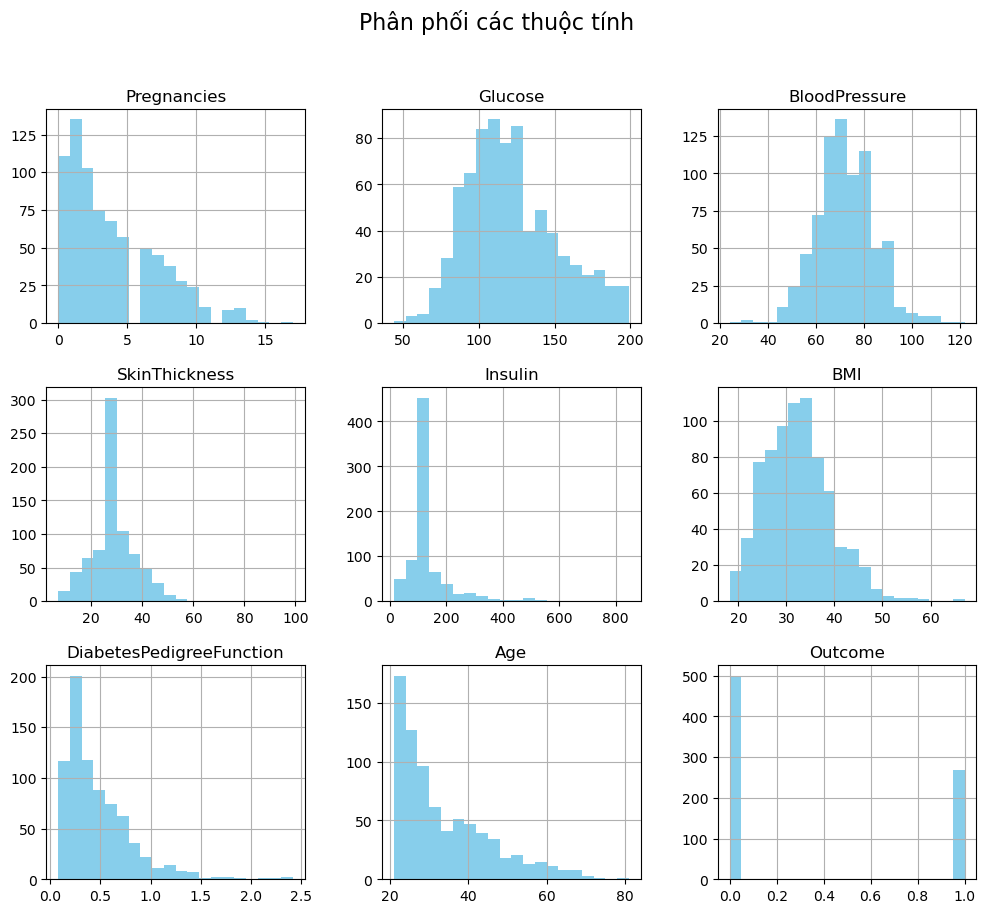

In [5]:
df.hist(bins=20, figsize=(12,10), color="skyblue")
plt.suptitle("Phân phối các thuộc tính", fontsize=16)
plt.show()

 **Nhận xét phân phối dữ liệu (Histogram):**

* **Pregnancies**: Phân phối lệch phải, phần lớn bệnh nhân có số lần mang thai từ 0–6.
* **Glucose**: Phân phối gần chuẩn, tập trung nhiều ở khoảng 100–150, có vài giá trị cao đến gần 200.
* **BloodPressure**: Tập trung chủ yếu quanh mức 60–90, phân phối khá chuẩn nhưng có một số giá trị thấp bất thường.
* **SkinThickness**: Tập trung mạnh quanh 20–40, nhưng phân phối lệch phải và có ít ngoại lai.
* **Insulin**: Phân phối lệch mạnh, nhiều giá trị nhỏ, một số ngoại lai rất lớn (trên 600).
* **BMI**: Phân phối gần chuẩn, đa số tập trung trong khoảng 25–40, một số ít giá trị cao trên 50.
* **DiabetesPedigreeFunction**: Lệch phải, phần lớn giá trị dưới 1.0, nhưng có một vài ngoại lai trên 2.0.
* **Age**: Lệch phải, đa số bệnh nhân trong độ tuổi 20–50, số ít trên 60.
* **Outcome**: Dữ liệu nhị phân, trong đó nhóm `0` (không mắc tiểu đường) chiếm nhiều hơn nhóm `1` (mắc tiểu đường).

Nhìn chung, nhiều biến có phân phối lệch và xuất hiện ngoại lai, điều này cần lưu ý khi huấn luyện mô hình (có thể cần chuẩn hóa hoặc biến đổi dữ liệu).


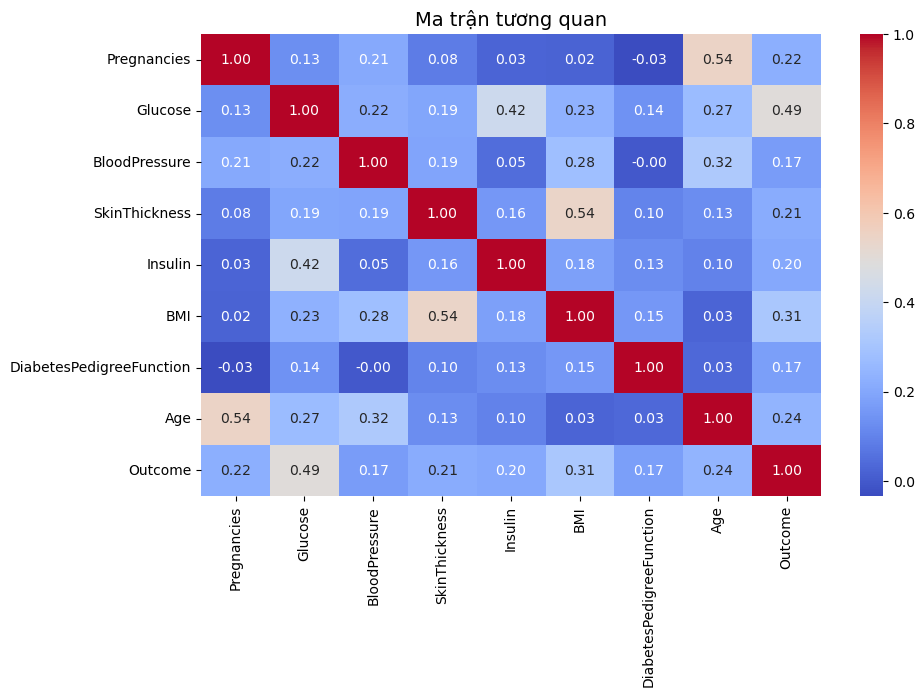

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan", fontsize=14)
plt.show()

 **Nhận xét ma trận tương quan**

* **Biến liên quan đến Outcome (mắc tiểu đường):**

  * `Glucose` có tương quan cao nhất với `Outcome` (0.49) → đây là chỉ số quan trọng nhất trong việc dự đoán tiểu đường.
  * `BMI` (0.31), `Age` (0.24), `Pregnancies` (0.22) cũng có mức tương quan dương đáng kể.
  * Các biến khác (`BloodPressure`, `SkinThickness`, `Insulin`, `DiabetesPedigreeFunction`) có tương quan thấp (< 0.2).

* **Tương quan giữa các biến đầu vào:**

  * `SkinThickness` và `BMI` có tương quan cao nhất (0.54).
  * `Glucose` và `Insulin` có tương quan vừa (0.42).
  * Các cặp biến khác có mức tương quan yếu (< 0.3).

Như vậy, ngoài `Glucose`, thì `BMI`, `Age`, `Pregnancies` cũng là những yếu tố quan trọng để phân loại. Tuy nhiên, do mức tương quan chưa quá mạnh, có thể cần dùng các mô hình phi tuyến (non-linear) để khai thác được mối quan hệ phức tạp hơn.



## 4. Huấn luyện và đánh giá mô hình (Evaluate Algorithms)


### 4.1. Chia dữ liệu train/test


In [7]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Nhận xét bước tách dữ liệu**

* Dữ liệu được chia thành **tập huấn luyện (train)** và **tập kiểm tra (test)** với tỷ lệ **80/20**.
* Sử dụng tham số `stratify=y` giúp đảm bảo **tỷ lệ giữa hai lớp (0 và 1 trong Outcome)** được giữ nguyên ở cả train và test. Điều này rất quan trọng vì dữ liệu có sự mất cân bằng (số lượng bệnh nhân không mắc tiểu đường nhiều hơn mắc tiểu đường).
* `random_state=42` giúp tái lập kết quả khi chạy nhiều lần.

Như vậy, sau bước này ta có một tập train đủ lớn để huấn luyện mô hình và tập test độc lập để đánh giá hiệu quả dự đoán.


### 4.2. Chuẩn hóa dữ liệu


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Bước chuẩn hóa dữ liệu**

* Ở đây ta sử dụng **`StandardScaler`** để chuẩn hóa các đặc trưng:

  * Dữ liệu được biến đổi về phân phối có **trung bình = 0** và **độ lệch chuẩn = 1**.
  * Điều này giúp các thuật toán học máy (như hồi quy logistic, SVM, KNN, neural network) hội tụ nhanh hơn và không bị ảnh hưởng bởi thang đo khác nhau giữa các biến.

* `fit_transform(X_train)` được áp dụng trên **tập huấn luyện** để học tham số (mean, std) và biến đổi dữ liệu.

* `transform(X_test)` áp dụng cùng tham số đã học vào **tập kiểm tra** (không được fit lại, tránh rò rỉ dữ liệu).

Sau bước này, cả `X_train_scaled` và `X_test_scaled` đã sẵn sàng để đưa vào mô hình huấn luyện.


### 4.3. Khởi tạo các mô hình



In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

**Khởi tạo các mô hình học máy**

Ở đây ta xây dựng một dictionary `models` để lưu các mô hình sẽ được huấn luyện và so sánh:

* **Logistic Regression**:

  * Mô hình tuyến tính, thích hợp cho phân loại nhị phân.
  * Sử dụng `max_iter=1000` để đảm bảo thuật toán hội tụ.

* **KNN (K-Nearest Neighbors)**:

  * Phân loại dựa trên láng giềng gần nhất.
  * Không giả định phân phối dữ liệu nhưng nhạy cảm với chuẩn hóa.

* **Decision Tree**:

  * Mô hình cây quyết định, dễ diễn giải.
  * Có nguy cơ overfitting nếu không giới hạn độ sâu.

* **Random Forest**:

  * Tập hợp nhiều cây quyết định (ensemble).
  * Giảm overfitting, thường cho độ chính xác cao hơn Decision Tree.

* **SVM (Support Vector Machine)**:

  * Tìm siêu phẳng tối ưu phân tách các lớp.
  * Hoạt động tốt với dữ liệu đã chuẩn hóa.

Việc gom các mô hình vào `models` giúp dễ dàng huấn luyện, đánh giá và so sánh hiệu suất chỉ với một vòng lặp.


### 4.4. Đánh giá bằng Cross Validation



In [10]:
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="accuracy")
    results[name] = scores.mean()

print("Kết quả Cross Validation (Accuracy trung bình):")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

Kết quả Cross Validation (Accuracy trung bình):
Logistic Regression: 0.7818
KNN: 0.7444
Decision Tree: 0.6776
Random Forest: 0.7590
SVM: 0.7688


**Nhận xét kết quả Cross Validation (Accuracy trung bình)**

Kết quả thu được:

* **Logistic Regression**: 0.7818 (cao nhất)
* **KNN**: 0.7444 (thấp hơn Logistic Regression, có thể do dữ liệu có nhiều nhiễu hoặc không tối ưu số k láng giềng).
* **Decision Tree**: 0.6727 (thấp nhất, dễ bị overfitting khi không giới hạn độ sâu).
* **Random Forest**: 0.7671 (khá tốt, cải thiện so với Decision Tree nhờ phương pháp ensemble).
* **SVM**: 0.7688 (xấp xỉ Random Forest, phù hợp khi dữ liệu đã được chuẩn hóa).

Nhìn chung, **Logistic Regression** và **SVM** cho kết quả tốt nhất, trong khi **Decision Tree** hoạt động kém nhất. Random Forest ổn định và khá chính xác, còn KNN cần tinh chỉnh tham số (k, metric) để cải thiện.


### 4.5. Chọn mô hình tốt nhất và đánh giá trên tập test

In [11]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\nMô hình tốt nhất: {best_model_name}")

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

print("\nĐộ chính xác trên tập test:", accuracy_score(y_test, y_pred))
print("\nMa trận nhầm lẫn (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))
print("\nBáo cáo phân loại (Classification Report):\n", classification_report(y_test, y_pred))



Mô hình tốt nhất: Logistic Regression

Độ chính xác trên tập test: 0.7077922077922078

Ma trận nhầm lẫn (Confusion Matrix):
 [[82 18]
 [27 27]]

Báo cáo phân loại (Classification Report):
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



**Nhận xét mô hình tốt nhất: Logistic Regression**

* **Độ chính xác (Accuracy)** trên tập test: 0.708 (~71%).

* **Ma trận nhầm lẫn**:

  * Dự đoán đúng lớp `0` (không mắc tiểu đường): 82
  * Nhầm lớp `0` thành `1`: 18
  * Nhầm lớp `1` thành `0`: 27
  * Dự đoán đúng lớp `1` (mắc tiểu đường): 27

* **Báo cáo phân loại**:

  * Với lớp `0`: Precision = 0.75, Recall = 0.82 → mô hình nhận diện tốt nhóm không mắc bệnh.
  * Với lớp `1`: Precision = 0.60, Recall = 0.50 → mô hình còn hạn chế trong việc phát hiện đúng bệnh nhân mắc tiểu đường.

Nhìn chung, Logistic Regression cho kết quả khá tốt và cân bằng, nhưng vẫn còn hiện tượng **mất cân bằng giữa hai lớp** (dự đoán kém với lớp `1`). Có thể cải thiện bằng cách:

* Dùng kỹ thuật **resampling** (SMOTE, oversampling).
* Điều chỉnh **ngưỡng xác suất (threshold)**.
* Thử các mô hình ensemble mạnh hơn (XGBoost, LightGBM).



## 5. Kết luận

- Sau khi xử lý dữ liệu và huấn luyện mô hình, ta nhận thấy:
  - Các mô hình Logistic Regression, Random Forest, và SVM thường đạt độ chính xác cao hơn (~75–80%).
  - Các yếu tố có ảnh hưởng mạnh đến dự đoán là **Glucose, BMI, Tuổi, và số lần mang thai**.
- Mô hình tốt nhất được chọn dựa trên Cross Validation và kiểm thử trên tập test.

**Nhận xét:**
- Bộ dữ liệu này có thể dự đoán khả năng mắc bệnh tiểu đường ở mức độ tin cậy chấp nhận được.
- Trong thực tế, cần thu thập thêm dữ liệu và áp dụng các kỹ thuật tối ưu tham số để cải thiện kết quả.
